In [1]:
import keras 
from keras import layers
from keras import backend as k
from keras.models import Model
from keras.utils import plot_model
import numpy as np

Using TensorFlow backend.


In [2]:
img_shape=(28,28,1)
batch_size=16
latent_dim=2

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(32, activation='relu')(x)
z_mean=layers.Dense(latent_dim)(x)
z_log_var=layers.Dense(latent_dim)(x)

In [3]:
def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0]
    dim=k.int_shape(z_mean)[1]
    epsilon=k.random_normal(shape=(batch,dim))
    return z_mean+k.exp(0.5*z_log_var)*epsilon
z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

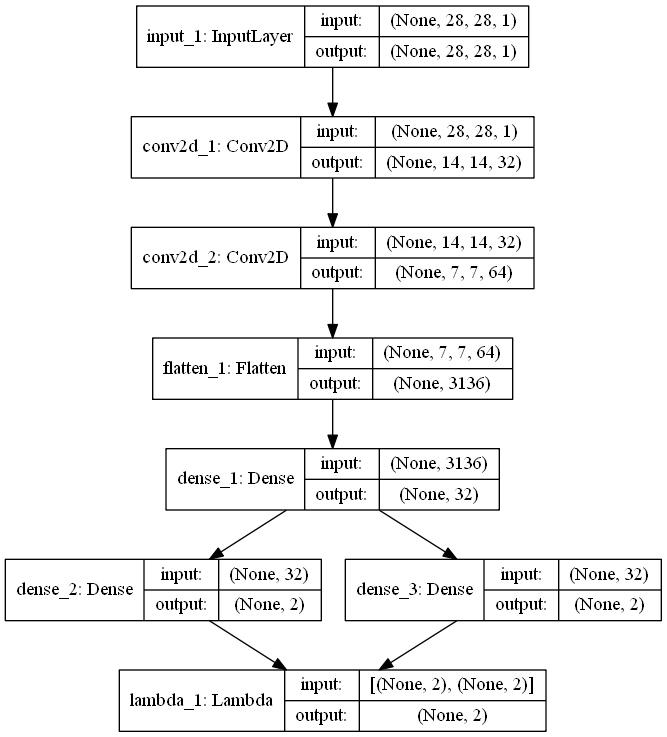

In [4]:
encoder=Model(input_img,[z_mean, z_log_var, z])
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

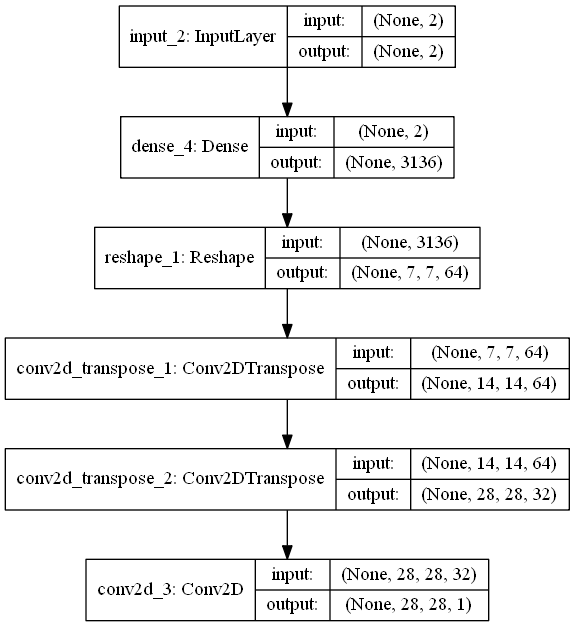

In [5]:
latent_input=layers.Input(shape=(latent_dim,))
x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input)
x=layers.Reshape(shape[1:])(x)
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [6]:
f_output=decoder(encoder(input_img)[2])
vae=Model(input_img, f_output)
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 119332    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         65089     
Total params: 184,421
Trainable params: 184,421
Non-trainable params: 0
_________________________________________________________________


In [7]:
input_img1=k.flatten(input_img)
f_output1=k.flatten(f_output)
print(input_img1, f_output1)
reconstruction_loss=keras.losses.mse(input_img1, f_output1)
reconstruction_loss*=input_img.shape[1]*input_img.shape[1]
inference_loss=1+z_log_var-k.square(z_mean)-k.exp(z_log_var)
inference_loss=k.sum(inference_loss, axis=-1)*-0.5
vae_loss=k.mean(reconstruction_loss+inference_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

Tensor("Reshape:0", shape=(None,), dtype=float32) Tensor("Reshape_2:0", shape=(None,), dtype=float32)


C:\Users\ysp\anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))


In [8]:
from keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/step - loss: 42.9766 - val_loss: 40.1205
Epoch 2/10
60000/60000 [==============================] - 73s 1ms/step - loss: 39.2743 - val_loss: 38.5610
Epoch 3/10
60000/60000 [==============================] - 73s 1ms/step - loss: 38.3605 - val_loss: 38.2494
Epoch 4/10
60000/60000 [==============================] - 73s 1ms/step - loss: 37.9033 - val_loss: 37.5769
Epoch 5/10
60000/60000 [==============================] - 73s 1ms/step - loss: 37.5782 - val_loss: 37.4688
Epoch 6/10
60000/60000 [==============================] - 72s 1ms/step - loss: 37.3489 - val_loss: 37.2485
Epoch 7/10
60000/60000 [==============================] - 72s 1ms/step - loss: 37.2206 - val_loss: 37.4021
Epoch 8/10
60000/60000 [==============================] - 72s 1ms/step - loss: 37.0943 - val_loss: 37.2619
Epoch 9/10
60000/60000 [==============================] - 73s 1ms/step - loss: 37.0422 - val_l

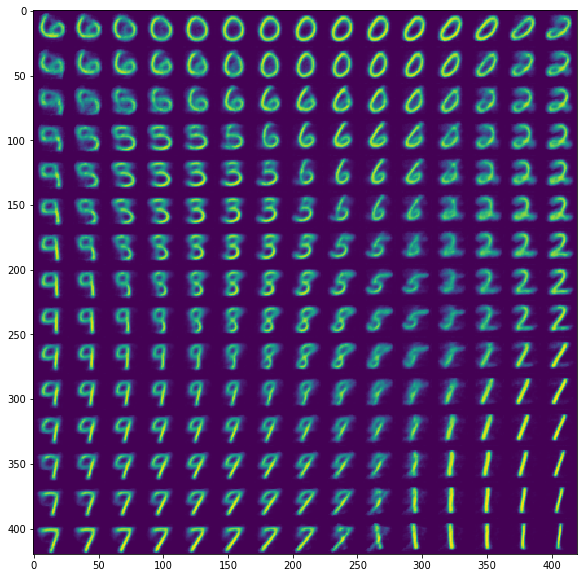

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n=15
image_size=28
figure=np.zeros((image_size*n,image_size*n))
z_x=norm.ppf(np.linspace(0.05,0.95,n))
z_y=norm.ppf(np.linspace(0.05,0.95,n))

for i,y in enumerate(z_y):
    for j, x in enumerate(z_x):
        z_sample=np.array([[x,y]])
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,2)
        x_decoded=decoder.predict(z_sample)
        digit=x_decoded[0].reshape(image_size, image_size)
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit

plt.figure(figsize=(10,10))
plt.imshow(figure)
plt.show()